<a href="https://colab.research.google.com/github/dUntouchable/ml_assignments/blob/master/wk2_Particle_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](https://github.com/hse-aml/hadron-collider-machine-learning/blob/master/week2/pic/pid.jpg?raw=1)

You task is to identify a particle type using the responses in the detector systems. 

# Attention

Data files you should download from https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2

wget did not work for me

!wget  https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2/test.csv.gz -O test.csv.gz
!wget  https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2/training.csv.gz -O training.csv.gz

In [0]:
from google.colab import drive
uploaded = drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/'

In [0]:
!wget https://raw.githubusercontent.com/hse-aml/hadron-collider-machine-learning/master/week2/utils.py -O utils.py

--2019-10-12 10:34:36--  https://raw.githubusercontent.com/hse-aml/hadron-collider-machine-learning/master/week2/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7634 (7.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.46K  --.-KB/s    in 0s      

2019-10-12 10:34:36 (48.2 MB/s) - ‘utils.py’ saved [7634/7634]



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

# Download data

Download data used to train classifiers.

### Read training file

In [0]:
data = pandas.read_csv(path +  'training.csv.gz')

In [0]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,Label,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
0,74791.156263,15.0,0.232275,1.0,1.0,3.2,-2.505719,6.604153,1.0,1.929960,17.585680,1.0,-6.411697,-7.213295,0.000001,1.467550,-26.667494,-2.730674,1.0,-5.152923,1.0,-999.000000,19.954819,3141.930677,0.613640,1.0,-0.909544,-999.000000,1.0,-0.661823,4.0,1.0,1.0,0.018913,5.366212,Muon,-21.913000,1.0,1.0,1.015345,28.0,1.0,-7.213300,-0.280200,5586.589846,1.0,1.0,10.422315,-2.081143e-07,-24.824400
1,2738.489989,15.0,-0.357748,0.0,1.0,3.2,1.864351,0.263651,1.0,-2.061959,20.230680,1.0,5.453014,0.000006,1531.542000,3.570540,-0.711194,1.773806,1.0,-999.000000,0.0,33.187644,0.037601,199.573653,0.465480,1.0,0.434909,13.667366,1.0,-999.000000,10.0,0.0,0.0,0.351206,9.144749,Ghost,-0.703617,0.0,1.0,-2.394644,32.0,1.0,-0.324317,1.707283,-0.000007,0.0,1.0,43.334935,2.771583e+00,-0.648017
2,2161.409908,17.0,-999.000000,0.0,0.0,-999.0,-999.000000,-999.000000,0.0,-999.000000,11.619878,0.0,-999.000000,-999.000000,-999.000000,0.826442,-999.000000,-999.000000,0.0,-999.000000,0.0,-999.000000,-999.000000,94.829418,0.241891,0.0,-999.000000,-999.000000,0.0,-999.000000,5.0,0.0,0.0,0.195717,1.459992,Ghost,-999.000000,0.0,0.0,-999.000000,27.0,0.0,-999.000000,-999.000000,-999.000000,0.0,0.0,-999.000000,-9.990000e+02,-999.000000
3,15277.730490,20.0,-0.638984,0.0,1.0,3.2,-2.533918,-8.724949,1.0,-3.253981,15.336305,1.0,-10.616585,-39.447507,4385.688000,1.076721,-29.291509,-3.053104,1.0,-999.000000,1.0,231.190351,2.839508,808.631064,0.680705,1.0,-1.504160,1939.259641,1.0,-999.000000,9.0,0.0,1.0,0.003972,22.950573,Pion,-47.223118,1.0,1.0,-0.321242,36.0,1.0,-35.202221,-14.742319,4482.803707,0.0,1.0,2.194175,-3.070819e+00,-29.291519
4,7563.700195,19.0,-0.638962,0.0,1.0,3.2,-2.087146,-7.060422,1.0,-0.995816,10.954629,1.0,-8.144945,26.050386,1220.930044,0.439767,21.386587,-2.730648,1.0,-999.000000,1.0,-794.866475,1.209193,1422.569214,0.575066,1.0,-1.576249,1867.165142,1.0,-999.000000,5.0,0.0,0.0,0.015232,3.516173,Proton,15.304688,0.0,1.0,-1.038026,33.0,1.0,25.084287,-10.272412,5107.554680,0.0,1.0,0.000015,-5.373712e+00,23.653087


### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### Look at the labels set

The training data contains six classes. Each class corresponds to a particle type. Your task is to predict type of a particle.

In [0]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Convert the particle types into class numbers.

In [0]:
data['Class'] = utils.get_class_ids(data.Label.values)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Define training features

The following set of features describe particle responses in the detector systems:

![features](https://github.com/hse-aml/hadron-collider-machine-learning/blob/master/week2/pic/features.jpeg?raw=1)

Also there are several combined features. The full list is following.

In [0]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['TrackPt',
 'HcalE',
 'DLLkaon',
 'MuonFlag',
 'HcalDLLbeElectron',
 'Calo2dFitQuality',
 'EcalE',
 'RICHpFlagKaon',
 'BremDLLbeElectron',
 'FlagHcal',
 'RICH_DLLbeElectron',
 'TrackQualityPerNDoF',
 'EcalDLLbeMuon',
 'FlagSpd',
 'RICH_DLLbeKaon',
 'DLLelectron',
 'TrackQualitySubdetector2',
 'EcalDLLbeElectron',
 'RICHpFlagElectron',
 'SpdE',
 'GhostProbability',
 'PrsDLLbeElectron',
 'RICH_DLLbeBCK',
 'FlagPrs',
 'Calo3dFitQuality',
 'FlagEcal',
 'TrackNDoFSubdetector2',
 'TrackNDoF',
 'PrsE',
 'MuonLooseFlag',
 'RICHpFlagPion',
 'TrackNDoFSubdetector1',
 'RICHpFlagProton',
 'FlagMuon',
 'MuonLLbeBCK',
 'DLLmuon',
 'FlagRICH2',
 'TrackP',
 'RICHpFlagMuon',
 'RICH_DLLbeProton',
 'FlagRICH1',
 'MuonLLbeMuon',
 'DLLproton',
 'HcalDLLbeMuon',
 'TrackDistanceToZ',
 'EcalShowerLongitudinalParameter',
 'FlagBrem',
 'TrackQualitySubdetector1',
 'RICH_DLLbeMuon']

### Divide training data into 2 parts

In [0]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.90)

In [0]:
len(training_data), len(validation_data)

(1080000, 120000)

# Sklearn classifier

On this step your task is to train **Sklearn** classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.3, random_state=13,
                                min_samples_leaf=100, max_depth=3)
gb.fit(training_data[features].values, training_data.Class.values)

CPU times: user 30min 36s, sys: 2.93 s, total: 30min 39s
Wall time: 30min 41s


### Log loss on the cross validation sample

In [0]:
# predict each track
proba_gb = gb.predict_proba(validation_data[features].values)

In [0]:
log_loss(validation_data.Class.values, proba_gb)

0.6660253076437698

# Keras neural network

On this step your task is to train **Keras** NN classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can. Data preprocessing may help you to improve your score.

In [0]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(100, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [0]:
nn = nn_model(len(features))
nn.fit(training_data[features].values, np_utils.to_categorical(training_data.Class.values), verbose=1, nb_epoch=5, batch_size=256)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  




Epoch 1/5





1080000/1080000 [==============================] - 10s 9us/step - loss: 1.3485
Epoch 2/5
1080000/1080000 [==============================] - 10s 9us/step - loss: 1.2254
Epoch 3/5
1080000/1080000 [==============================] - 9s 9us/step - loss: 1.1428
Epoch 4/5
1080000/1080000 [==============================] - 9s 8us/step - loss: 1.0997
Epoch 5/5
1080000/1080000 [==============================] - 9s 8us/step - loss: 1.0702


### Log loss on the cross validation sample

In [0]:
# predict each track
proba_nn = nn.predict_proba(validation_data[features].values)

In [0]:
log_loss(validation_data.Class.values, proba_nn)

1.066806478341484

# Quality metrics

Plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [0]:
proba = proba_gb

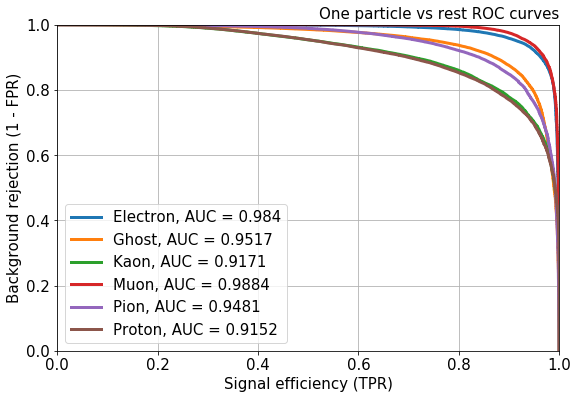

In [0]:
utils.plot_roc_curves(proba, validation_data.Class.values)

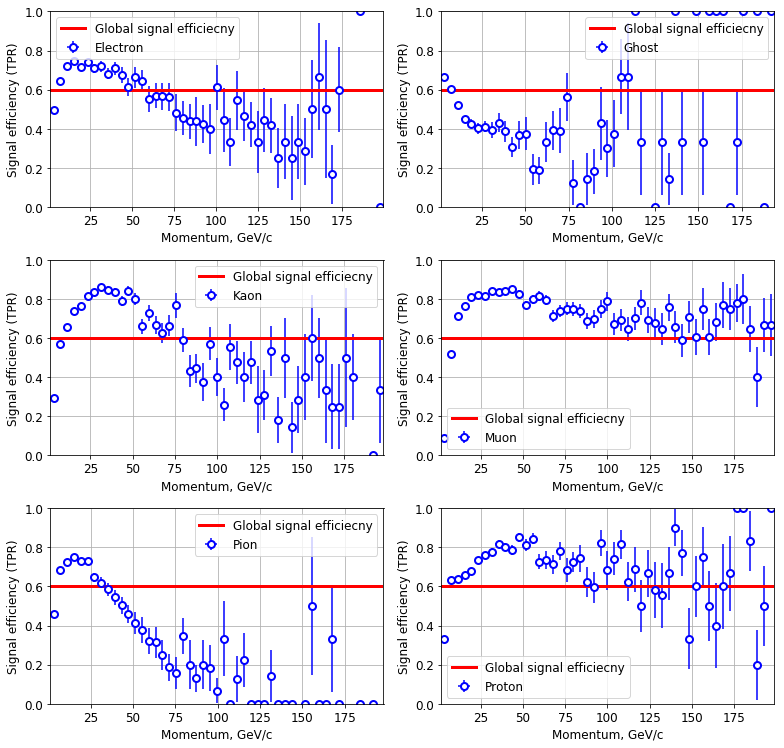

In [0]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

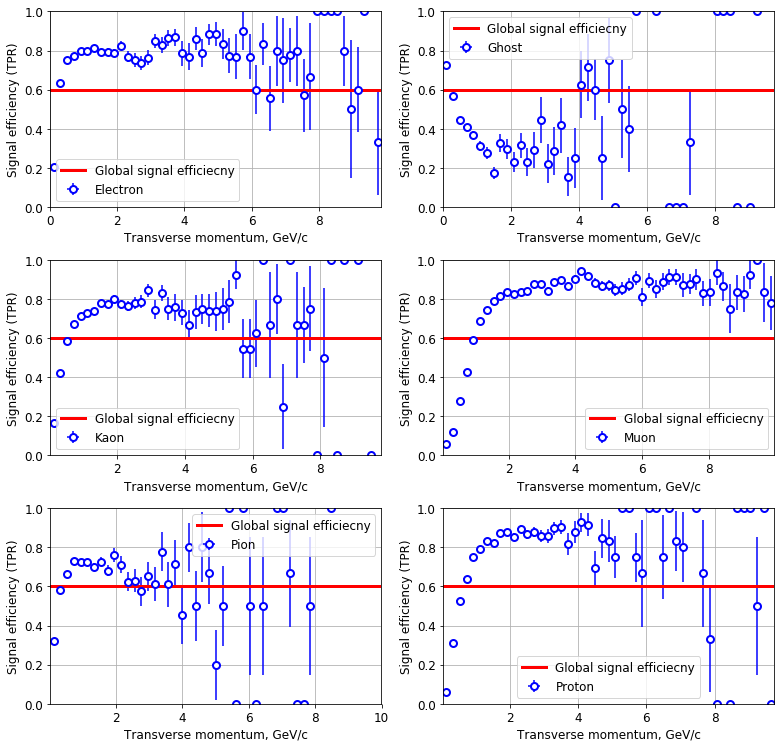

In [0]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()

# Prepare submission

Select your best classifier and prepare submission file.

In [0]:
test = pandas.read_csv(path + 'test.csv.gz')

In [0]:
best_model = gb

In [0]:
# predict test sample
submit_proba = best_model.predict_proba(test[features])
submit_ids = test.ID

In [0]:
from IPython.display import FileLink
utils.create_solution(submit_ids, submit_proba, filename='submission_file.csv.gz')

/content/submission_file.csv.gz

In [0]:
!ls

gdrive	     sample_data	     test.csv.gz      utils.py
__pycache__  submission_file.csv.gz  training.csv.gz


In [0]:
!cp submission_file.csv.gz /content/gdrive/'My Drive'/